In [1]:
import os
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.classes = os.listdir(self.root_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                self.paths.append(os.path.join(class_dir, filename))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image_path = self.paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        return image, label

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()  
])

dataset = CustomDataset(root_dir='C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/Train-adj/', transform = train_transforms)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [4]:
test_dataset = datasets.ImageFolder(os.path.dirname('C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/test-no-labels/'), transform = train_transforms)


test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
class SimpleCNN_x(nn.Module):
    def __init__(self, num_classes=12):  
        super(SimpleCNN_x, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        #self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(32768, 128)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x1 = self.pool(x1)
        x2 = F.relu(self.conv2(x1))
        x3 = self.pool(x2)
        x3 = self.dropout(x3)
        # x4 = self.pool(F.relu(self.conv3(x3)))
        # x4 = self.dropout(x4)
        x5 = x3.view(x3.size(0), -1)  
        x6 = F.relu(self.fc1(x5))
        x6 = self.dropout(x6)
        out = self.fc2(x6)
        return x1, x2, out

c:\Users\denis\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/10], Step [0/944], Loss: 2.4928
Epoch [1/10], Step [100/944], Loss: 2.3999
Epoch [1/10], Step [200/944], Loss: 2.1865
Epoch [1/10], Step [300/944], Loss: 2.2513
Epoch [1/10], Step [400/944], Loss: 2.1539
Epoch [1/10], Step [500/944], Loss: 2.0265
Epoch [1/10], Step [600/944], Loss: 1.9953
Epoch [1/10], Step [700/944], Loss: 1.8267
Epoch [1/10], Step [800/944], Loss: 1.5723
Epoch [1/10], Step [900/944], Loss: 1.5639
Epoch [1/10], Average Loss: 2.0692
Epoch [2/10], Step [0/944], Loss: 1.4851
Epoch [2/10], Step [100/944], Loss: 1.7197
Epoch [2/10], Step [200/944], Loss: 1.4234
Epoch [2/10], Step [300/944], Loss: 1.3300
Epoch [2/10], Step [400/944], Loss: 1.2164
Epoch [2/10], Step [500/944], Loss: 1.1449
Epoch [2/10], Step [600/944], Loss: 1.3337
Epoch [2/10], Step [700/944], Loss: 1.0119
Epoch [2/10], Step [800/944], Loss: 0.9921
Epoch [2/10], Step [900/944], Loss: 1.1394
Epoch [2/10], Average Loss: 1.2793
Epoch [3/10], Step [0/944], Loss: 0.9589
Epoch [3/10], Step [100/944], Los

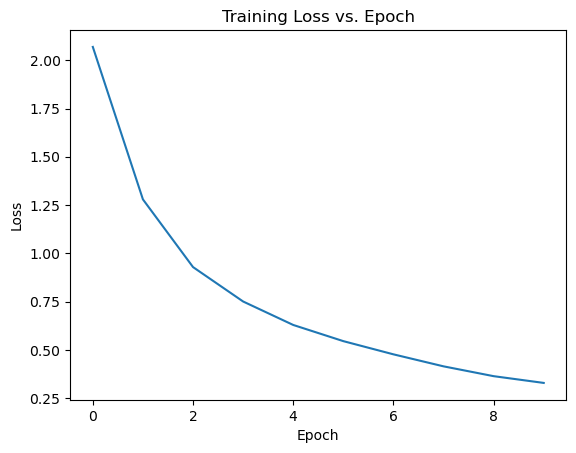

Training complete.


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN_x().to(device)
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

num_epochs = 10

loss_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

       
        _, _, outputs = model(data)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()

     
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:  
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}')

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.show()

print("Training complete.")

In [8]:
import matplotlib.pyplot as plt

c_names = ['1','2','12','13','14','15','17','23','25','26','28','33']

def test_images(model, device, image_tensors, class_names):

    assert image_tensors.size(0) == 10
    
    
    model.eval()
    image_tensors = image_tensors.to(device)
    
    with torch.no_grad():
        _, _, outputs = model(image_tensors)
        _, predicted_indices = outputs.max(1)  

    plt.figure(figsize=(20, 10))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        predicted_class = class_names[predicted_indices[i].item()]
        
    
        np_image = image_tensors[i].cpu().numpy().transpose((1, 2, 0))
        plt.imshow(np_image)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')  

    plt.tight_layout()
    plt.show()


c:\Users\denis\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


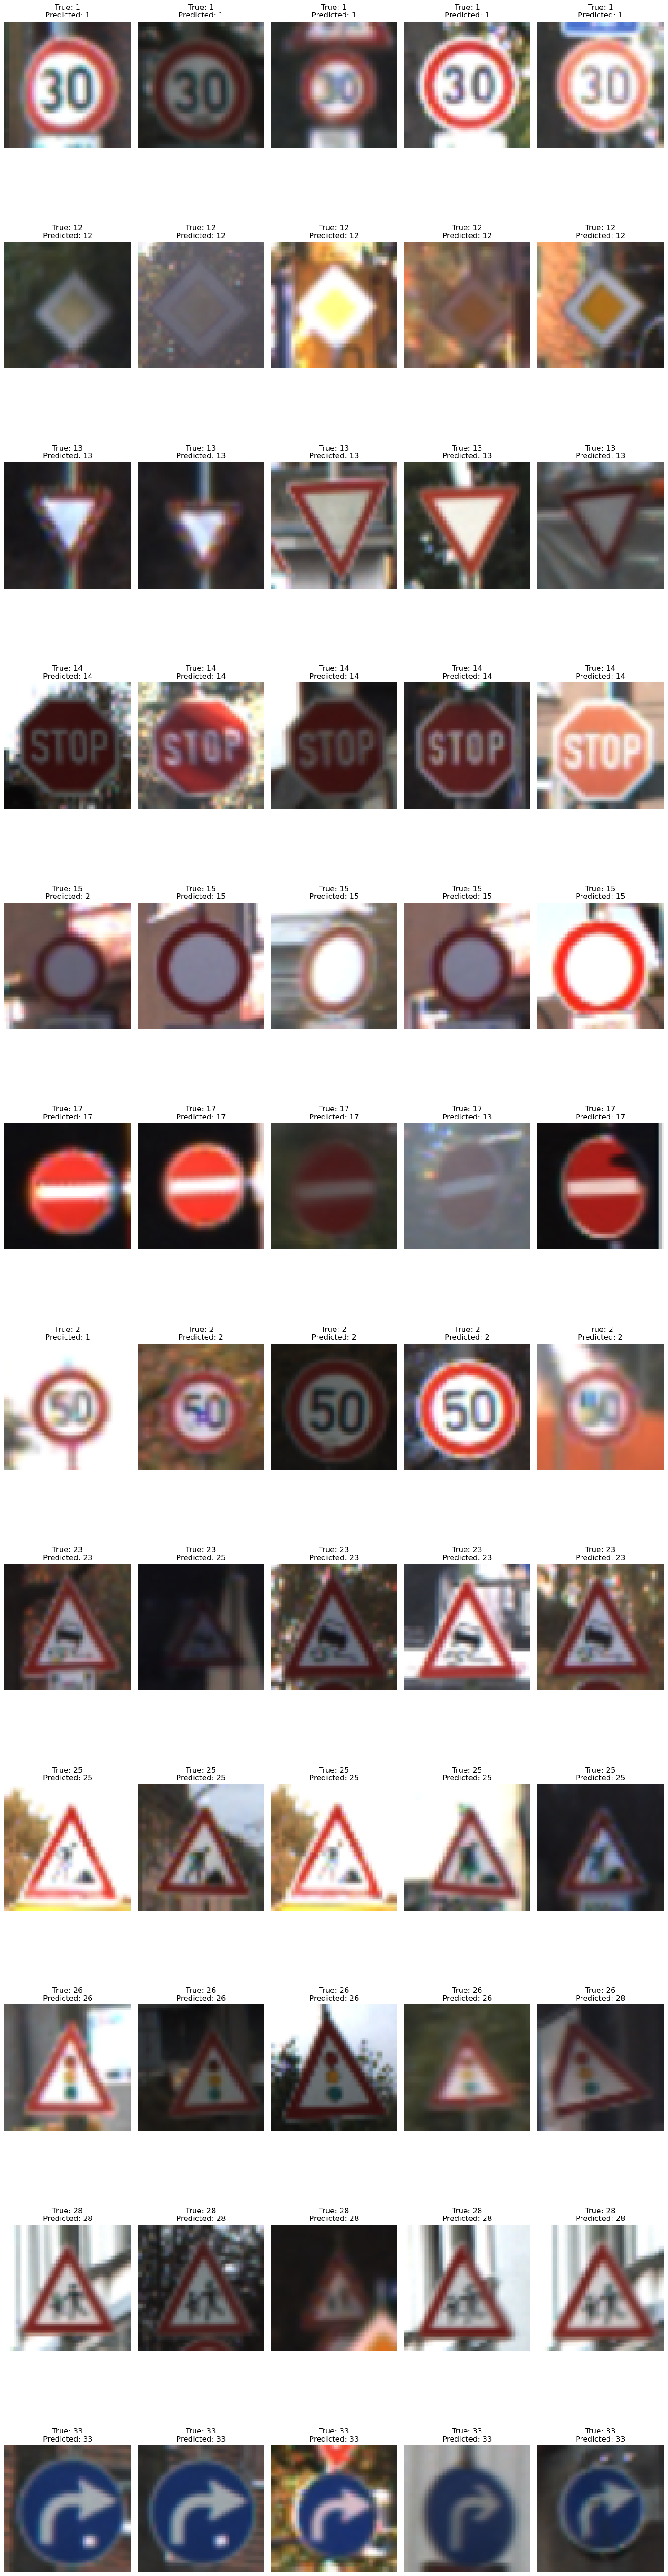

In [13]:
import matplotlib.pyplot as plt
def display_predictions(dataset, model, num_images=25, num_columns=5):
   
    num_rows = int(num_images / num_columns) + (num_images % num_columns > 0)
    
    plt.figure(figsize=(15, 5*num_rows))
    for i in range(num_images):
        image, true_label = dataset[i]
        
    
        input_tensor = image.unsqueeze(0).to(device)
       
    
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted_label = torch.max(outputs[2], 1)
        
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        
        plt.subplot(num_rows, num_columns, i+1)
        plt.imshow(image)
        plt.title(f"True: {dataset.classes[true_label]}\nPredicted: {dataset.classes[predicted_label.item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions(test_dataset, model, num_images=12*5)